In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Datasets and its preprocessing

In [3]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

transform_test = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

In [4]:
trainset = torchvision.datasets.CIFAR10(root = "./data", train=True, download=True,
                                        transform=transform_train)
testset = torchvision.datasets.CIFAR10(root = "./data", train=False, download=True,
                                      transform=transform_test)

Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
no_of_classes = 10
batch_size = 4

In [6]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size,True)

In [9]:
dataiter = iter(trainloader)
images,labels = dataiter.next()

print(images.shape)
print(images[1].shape)
print(labels[1])

torch.Size([4, 3, 224, 224])
torch.Size([3, 224, 224])
tensor(5)


In [17]:
def imshow(img, title):
    npimg = img.numpy() / 2 + 0.5
    plt.figure(figsize=(batch_size,1))
    plt.axis('off')
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

In [18]:
def show_batch_images(dataloader):
    images,labels = next(iter(dataloader))
    img = torchvision.utils.make_grid(images)
    imshow(img,title=[str(x.item()) for x in labels])

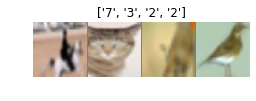

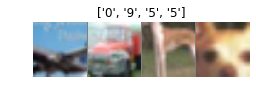

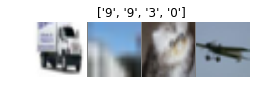

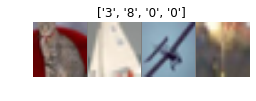

In [19]:
for i in range(batch_size):
    show_batch_images(trainloader)

# creating VGG16

In [20]:
from torchvision import models

In [21]:
vgg = models.vgg16_bn()

In [22]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [25]:
# print(vgg.features)
print(vgg.features[0])

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [26]:
print(vgg.classifier[6])

Linear(in_features=4096, out_features=1000, bias=True)


In [29]:
final_in_features = vgg.classifier[6].in_features
final_in_features

4096

In [28]:
mod_classifier = list(vgg.classifier.children())[:-1]
mod_classifier

[Linear(in_features=25088, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=4096, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False)]

In [30]:
mod_classifier.extend([nn.Linear(final_in_features,no_of_classes)])

In [31]:
mod_classifier

[Linear(in_features=25088, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=4096, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=4096, out_features=10, bias=True)]

In [34]:
vgg.classifier = nn.Sequential(*mod_classifier)
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [35]:
batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset,batch_size,True)
testloader = torch.utils.data.DataLoader(testset,batch_size,False)

In [36]:
def evaluation(dataloader, model):
    total,correct =0 ,0
    for data in dataloader:
        inputs,labels = data
        inputs,labels =inputs.to(device),labels.to(device)
        outputs = model(inputs)
        _,pred = torch.max(outputs.data,1)
        total += labels.size(0)
        correct += (pred==labels).sum().item()
    return 100 * correct/total

In [37]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adagrad(vgg.parameters())

In [ ]:
loss_epoch_arr = []
max_epochs = 1

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):
    for i,data in enumerate(trainloader,0):
        
        inputs,labels = data
        inputs,labels =inputs.to(device),labels.to(device)
        
        opt.zero_grad()
        outputs = vgg(inputs)
        loss= loss_fn(outputs,labels)
        loss.backward()
        opt.step()
        
        del inputs ,labels,outputs
        torch.cuda.empty_cache()
        
        if i % 100 ==0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
        
        loss_epoch_arr.append(loss.item())
        
        print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation(testloader, vgg), evaluation(trainloader, vgg)))
        
plt.plot(loss_epoch_arr)
plt.show()

Iteration: 0/3125, Loss: 2.71
